## Mask R-CNN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import keras

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "/data/dayajun/sw/Mask_RCNN/logs/particles20180919T1858/mask_rcnn_particles_0100.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "/data/dayajun/sw/Mask_RCNN/logs/particles20180919T1858/mask_rcnn_particles_0100.h5")

Using TensorFlow backend.


## Configurations

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# sys.path.insert(0, '/data/dayajun/sw/Mask_RCNN/samples/shapes/')
# import shapes
# config = shapes.ShapesConfig()

# # MS COCO Dataset
# import coco
# config = coco.CocoConfig()

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
# DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
from mrcnn.config import Config

class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Particles"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE_STRIDES = [4, 8, 16, 32, 64, 128, 256]
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # background + particles

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_RATIOS = [0.5,  1,  2,  4,   8,  16, 32]
    RPN_ANCHOR_SCALES = (8  , 16, 32, 64, 128, 256, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    DETECTION_MAX_INSTANCES = 10

In [7]:
config=ShapesConfig()
print config.NAME
config.display()

Particles

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64, 128, 256]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 2

## Load Model

In [16]:
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "/data/dayajun/sw/Mask_RCNN/logs/particles20180919T1858/mask_rcnn_particles_0009.h5")

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Create model in inference mode
# with tf.device(DEVICE):
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,config=config)

# Set weights file path
if config.NAME == "Particles":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

('Loading weights ', '/data/dayajun/sw/Mask_RCNN/logs/particles20180919T1858/mask_rcnn_particles_0009.h5')
Re-starting from epoch 9


## Review Weight Stats

In [18]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1_4/kernel:0,"(7, 7, 3, 64)",-0.0427,+0.0427,+0.0249
conv1_4/bias:0,"(64,)",+0.0000,+0.0000,+0.0000
bn_conv1_4/gamma:0*** dead?,"(64,)",+1.0000,+1.0000,+0.0000
bn_conv1_4/beta:0*** dead?,"(64,)",+0.0000,+0.0000,+0.0000
bn_conv1_4/moving_mean:0*** dead?,"(64,)",+0.0000,+0.0000,+0.0000
bn_conv1_4/moving_variance:0*** dead?,"(64,)",+1.0000,+1.0000,+0.0000
res2a_branch2a_4/kernel:0,"(1, 1, 64, 64)",-0.2165,+0.2164,+0.1252
res2a_branch2a_4/bias:0,"(64,)",+0.0000,+0.0000,+0.0000
bn2a_branch2a_4/gamma:0*** dead?,"(64,)",+1.0000,+1.0000,+0.0000
bn2a_branch2a_4/beta:0*** dead?,"(64,)",+0.0000,+0.0000,+0.0000


# Histograms of Weights

TODO: cleanup this part

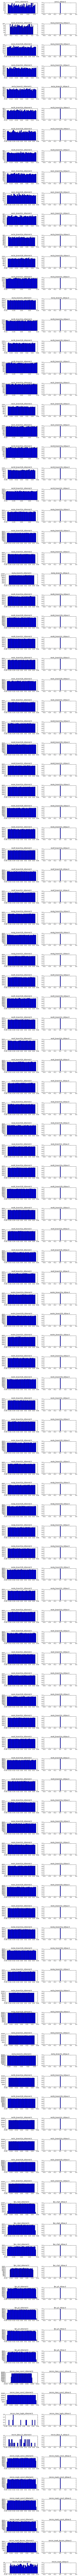

In [17]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)
